<a href="https://colab.research.google.com/github/Abdansb/-KODE--Tensorflow-RNN/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bidirectional LSTM Ticket Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [ ]:
!pip install tensorflow==2.8.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboard.plugins import projector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

## Logging Setup

In [ ]:
# Define a function to log hyperparameters and results
def log_results(log_file, params, results):
    with open(log_file, 'a') as f:
        f.write("Timestamp: {}\n".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
        f.write("Results:\n")
        for key, value in results.items():
            f.write(f"{key}: {value}\n")
        f.write("\n" + "="*50 + "\n\n")

## Hyperparams

In [ ]:
VAL_SPLIT = 0.3
TEST_SPLIT = 0.2
BUFFER_SIZE = 10000   # Prefetching
BATCH_SIZE = 64
VOCAB_SIZE = 4000
EPOCHS = 15
LSTM_UNIT = 64
OPTIMIZER = "RMSProp"

## Adasyn (Experimental)

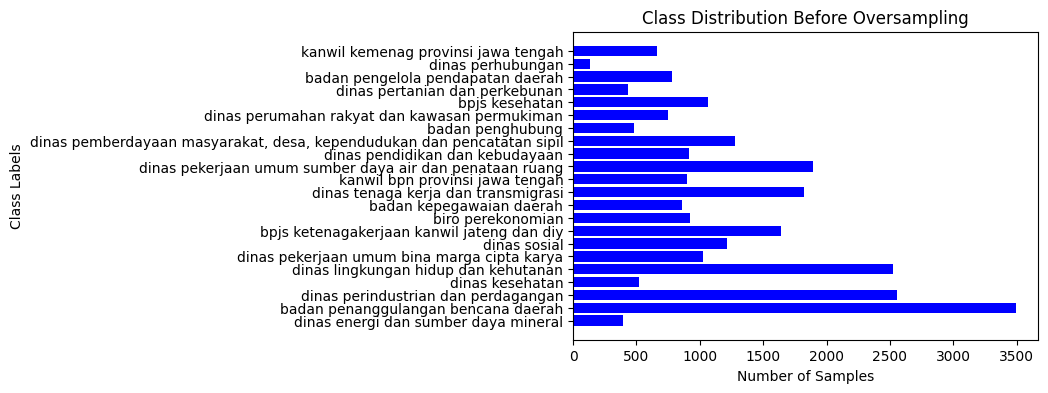

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


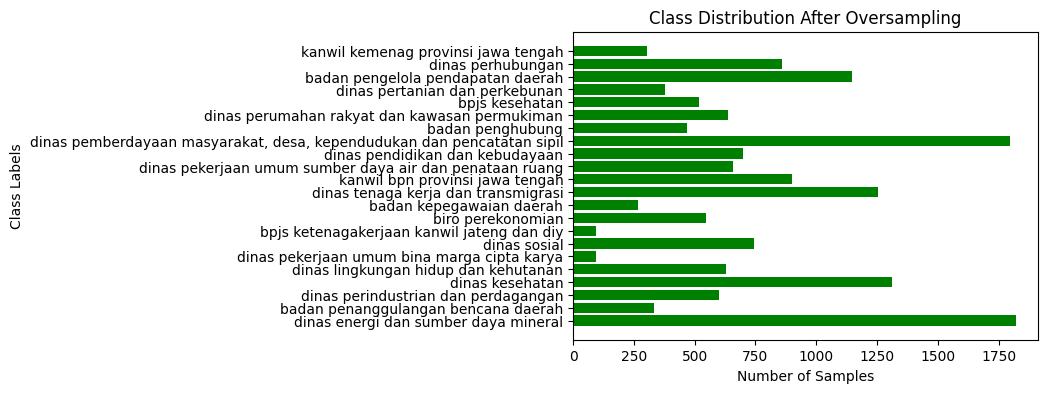

Train len (after resampling):  16059
Val len:  6304
Test len:  1577


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from collections import Counter



# Load the preprocessed dataset
dataset = pd.read_csv("/content/drive/MyDrive/Skripsi/delapan juni stemmed.csv")

# Assuming you have text_messages and department_labels arrays
text_messages = dataset["Message"].fillna('')  # Ensure no NaN values
department_labels = dataset["Departement"]

# Convert department labels to numerical format
label_map = {label: index for index, label in enumerate(set(department_labels))}
numerical_labels = [label_map[label] for label in department_labels]

# Count the number of samples per class before oversampling
class_counts_before = Counter(numerical_labels)
# Visualize the class distribution before oversampling
plt.figure(figsize=(6, 4))
plt.barh(list(label_map.keys()), class_counts_before.values(), color='blue')
plt.ylabel('Class Labels')
plt.xlabel('Number of Samples')
plt.title('Class Distribution Before Oversampling')
plt.show()

# Split dataset into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    text_messages, numerical_labels, test_size=VAL_SPLIT, random_state=42
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=TEST_SPLIT, random_state=42
)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=VOCAB_SIZE)
train_features = vectorizer.fit_transform(train_text).toarray()

# Apply ADASYN to balance the dataset
"""adasyn = ADASYN(sampling_strategy='all', random_state=42, n_neighbors=5)
train_features_resampled, train_labels_resampled = adasyn.fit_resample(train_features, train_labels)"""

# Apply ClusterCentroids to undersample the dataset
undersampler = ClusterCentroids(sampling_strategy='majority', random_state=42, voting='hard')
train_features_resampled, train_labels_resampled = undersampler.fit_resample(train_features, train_labels)


# Count the number of samples per class after oversampling
class_counts_after = Counter(train_labels_resampled)
# Visualize the class distribution after oversampling
plt.figure(figsize=(6, 4))
plt.barh(list(label_map.keys()), class_counts_after.values(), color='green')
plt.ylabel('Class Labels')
plt.xlabel('Number of Samples')
plt.title('Class Distribution After Oversampling')
plt.show()

# Convert resampled features back to text form (if needed for further processing)
train_text_resampled = vectorizer.inverse_transform(train_features_resampled)
train_text_resampled = [' '.join(text) for text in train_text_resampled]

# Create TensorFlow datasets from the resampled data
train_dataset = tf.data.Dataset.from_tensor_slices((train_text_resampled, train_labels_resampled))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels))

train_dataset = (
    train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.padded_batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Initialize and adapt TextVectorization
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(tf.data.Dataset.from_tensor_slices(train_text_resampled).batch(BATCH_SIZE).map(lambda x: tf.strings.lower(x)))

print("Train len (after resampling): ", len(train_text_resampled))
print("Val len: ", len(val_text))
print("Test len: ", len(test_text))


## Dataset

### Extract

In [ ]:
# Load the preprocessed dataset
dataset = pd.read_csv("/content/drive/MyDrive/Skripsi/delapan juni stemmed.csv")

# Assuming you have text_messages and department_labels arrays
text_messages = dataset["Message"]
department_labels = dataset["Departement"]

# Convert department labels to numerical format
label_map = {label: index for index, label in enumerate(set(department_labels))}
numerical_labels = [label_map[label] for label in department_labels]

# Split dataset into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    text_messages, numerical_labels, test_size=VAL_SPLIT, random_state=42
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=TEST_SPLIT, random_state=42
)

train_text.fillna(value='', inplace=True)
val_text.fillna(value='', inplace=True)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels))

print("Train len: ", len(train_text))
print("Val len: ", len(val_text))
print("Test len: ", len(test_text))


Train len:  18387
Val len:  6304
Test len:  1577


In [ ]:
for example, label in train_dataset.take(3):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  [b'adik bayar biaya brebes buat hapus hidup juta kan kembali kemudian minta ngga pa permisi saran sarana sekolah smk sya tp uang un'
 b'jalan lubang monggo'
 b'alamat bagaimana barat camat covid derita kabupaten lapor lurah manyar masuk mekanisme punya rs semarang utk yg'
 b'bahan baku banyak bapak bojong desa dunia ekspor gubernur gulung henti jawa kalau karena kasi kec kerja kurang luar magelang mahal masalah mohon mungkin negeri negri padahal rajin sangat sapu segera seluruh serap tenaga tengah tikar'
 b'ada aju alaikum arah assalamu bpk buat budi cara disposisi huni iii jakarta jateng jawa kab kategori kerja lanjut layak lihat malang masyarakat menteri miskin no notabene panggil program prosedur pupr rasa respon rtlh rumah salah satu sekarang sesuai swadaya terimakasih terus tindak tri usaha usul yg'
 b'akses bojong cilacap daerah desa ga gubernur hormat jati jl jln kabupaten kampung kasih kec kota lokasi majenang mohon nya pa padahal pernah salam satu terima timbang tuju'
 

In [ ]:
train_dataset = (
    train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.padded_batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
    print("texts: ", example.numpy()[:3])
    print()
    print("labels: ", label.numpy()[:3])

texts:  [b'apa atas berapa biaya bpak bsa byar cinta coba ds gk gratis gubernur heran kab kalo kan kec kemarin kn kok kwitansi ky laku lg lokasi lurah malah mau minta mutih ngurus pagi pak prosedur pungut rb sari selamat sendiri sertifikasi smoga suruh sy sya tahu tanah tanya tempat tindak tp trmksh tugas untk yg'
 b'anak bayi brp bulan dpt informasi kabupaten kasih kebumen kosong lama mohon orangtua terima tunggu utk vaksin'
 b'bantu banyumas jalan kalibagor kaliori lampu mohon pak patikraja provinsi selamat siang tepat terang wetan wlahar']

labels:  [16  3 20]


### Encoder

In [ ]:
"""@tf.keras.utils.register_keras_serializable()
class MyTextVectorization(tf.keras.layers.TextVectorization):
    pass
# Then use MyTextVectorization instead of TextVectorization in your model
encoder = MyTextVectorization(max_tokens=VOCAB_SIZE)"""


encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(tf.data.Dataset.from_tensor_slices(train_text).batch(BATCH_SIZE).map(lambda x: tf.strings.lower(x)))


In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:70]

array(['', '[UNK]', 'pak', 'mohon', 'yg', 'lapor', 'mau', 'ganjar',
       'bantu', 'desa', 'camat', 'kabupaten', 'kerja', 'jadi', 'gubernur',
       'jalan', 'terima', 'kasih', 'bapak', 'kab', 'tanya', 'alamat',
       'buat', 'banyak', 'selamat', 'kota', 'hari', 'lurah', 'bpjs',
       'minta', 'warga', 'terimakasih', 'sangat', 'padahal', 'bulan',
       'nya', 'sekarang', 'tindak', 'apa', 'kec', 'maaf', 'bayar',
       'tahun', 'orang', 'rumah', 'lama', 'sebut', 'atas', 'lanjut',
       'sama', 'assalamualaikum', 'usaha', 'nama', 'pihak', 'baik',
       'lebih', 'dapat', 'tengah', 'perintah', 'ketenagakerjaan', 'lalu',
       'kata', 'tp', 'kurang', 'kena', 'baru', 'punya', 'dr', 'satu',
       'jawa'], dtype='<U17')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  38,   47,  428,   99,  961,  713, 1920, 1211,  298,  359,  263,
         399,   14,  720,   19,  133,  119,   39,  241, 1147,   70, 1394,
        3686,   78,  384,  202,   27,  160,    6,   29,  924,  545,   93,
           2,  383,  759,  272, 1345,   24,  145, 1683, 2377,  167,  128,
         291,  192,  124,   20,   86,   37,   62, 1573,  172,  803,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  95, 1309, 1670,   34,  251,  270,   11,   17,  451,  692,   45,
           3, 1893,   16,  232,  193,  709,    0,    0,    0,    0,

In [ ]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'apa atas berapa biaya bpak bsa byar cinta coba ds gk gratis gubernur heran kab kalo kan kec kemarin kn kok kwitansi ky laku lg lokasi lurah malah mau minta mutih ngurus pagi pak prosedur pungut rb sari selamat sendiri sertifikasi smoga suruh sy sya tahu tanah tanya tempat tindak tp trmksh tugas untk yg'
Round-trip:  apa atas berapa biaya bpak bsa byar cinta coba ds gk gratis gubernur heran kab kalo kan kec kemarin kn kok kwitansi ky laku lg lokasi lurah malah mau minta mutih ngurus pagi pak prosedur pungut rb sari selamat sendiri sertifikasi smoga suruh sy sya tahu tanah tanya tempat tindak tp trmksh tugas untk yg                                                                        

Original:  b'anak bayi brp bulan dpt informasi kabupaten kasih kebumen kosong lama mohon orangtua terima tunggu utk vaksin'
Round-trip:  anak bayi brp bulan dpt informasi kabupaten kasih kebumen kosong lama mohon orangtua terima tunggu utk vaksin                                              

In [ ]:
total_train_samples = len(train_text)
total_val_samples = len(val_text)

# Calculate the number of epochs
# Assuming each epoch goes through the entire training dataset
num_epochs = 10

# Calculate steps per epoch
# Steps per epoch should be total_train_samples divided by batch size
steps_per_epoch = total_train_samples // BATCH_SIZE

# Calculate validation steps
# Validation steps should be total_val_samples divided by batch size
validation_steps = total_val_samples // BATCH_SIZE

print("Train len: ", len(train_text))
print("Val len: ", len(val_text))
print("Test len: ", len(test_text))
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Train len:  18387
Val len:  6304
Test len:  1577
Steps per epoch: 287
Validation steps: 98


## Model

### Layer

In [ ]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNIT)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(label_map), activation="softmax"),
    ]
)

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    #batch_size = 64,
    #steps_per_epoch = 714,
    epochs=EPOCHS,
    validation_data=val_dataset,
    #validation_steps=275
)

Epoch 1/15
251/251 [==============================] - 90s 318ms/step - loss: 2.5899 - accuracy: 0.2158 - val_loss: 2.5938 - val_accuracy: 0.2939
Epoch 2/15
251/251 [==============================] - 74s 294ms/step - loss: 1.8517 - accuracy: 0.4486 - val_loss: 1.9558 - val_accuracy: 0.4822
Epoch 3/15
251/251 [==============================] - 76s 305ms/step - loss: 1.4071 - accuracy: 0.5938 - val_loss: 1.7455 - val_accuracy: 0.5600
Epoch 4/15
251/251 [==============================] - 75s 298ms/step - loss: 1.1288 - accuracy: 0.6835 - val_loss: 1.5953 - val_accuracy: 0.6120
Epoch 5/15
251/251 [==============================] - 75s 300ms/step - loss: 0.9449 - accuracy: 0.7372 - val_loss: 1.4871 - val_accuracy: 0.6248
Epoch 6/15
251/251 [==============================] - 78s 312ms/step - loss: 0.8108 - accuracy: 0.7738 - val_loss: 1.4003 - val_accuracy: 0.6550
Epoch 7/15
251/251 [==============================] - 74s 296ms/step - loss: 0.7234 - accuracy: 0.8024 - val_loss: 1.4116 - val_ac

### Testing

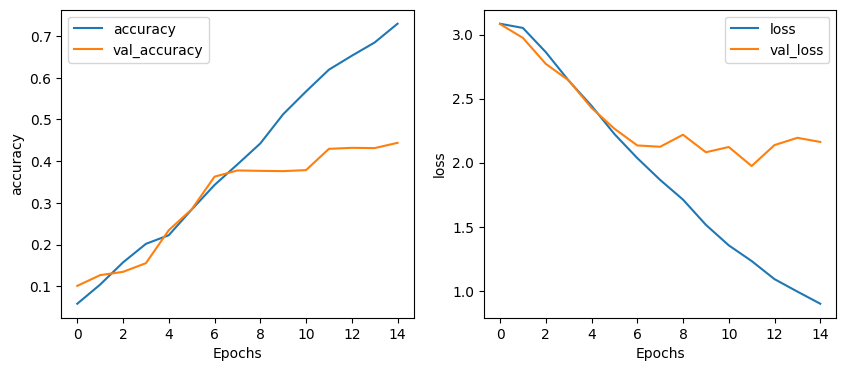

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

result_log = {
    'loss': test_loss,
    'accuracy': test_acc
}

25/25 [==============================] - 4s 175ms/step - loss: 2.2022 - accuracy: 0.4547
Test Loss: 2.2021875381469727
Test Accuracy: 0.4546607434749603


In [ ]:
# LOGGING!
hyperparameters = {
    'VAL_SPLIT': VAL_SPLIT,
    'TEST_SPLIT': TEST_SPLIT,
    'BUFFER_SIZE': BUFFER_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'VOCAB_SIZE': VOCAB_SIZE,
    'EPOCHS': EPOCHS,
    'LSTM_UNIT': LSTM_UNIT,
    'OPTIMIZER': OPTIMIZER
}

# Generate a log filename based on the current date and time
timestamp = datetime.now().strftime("%m%d_%H%M")
log_file = f"training_log_{timestamp}_{round(test_acc,2)}.txt"

log_results(log_file, hyperparameters, result_log)
print(f"Training complete and results logged in {log_file}.")

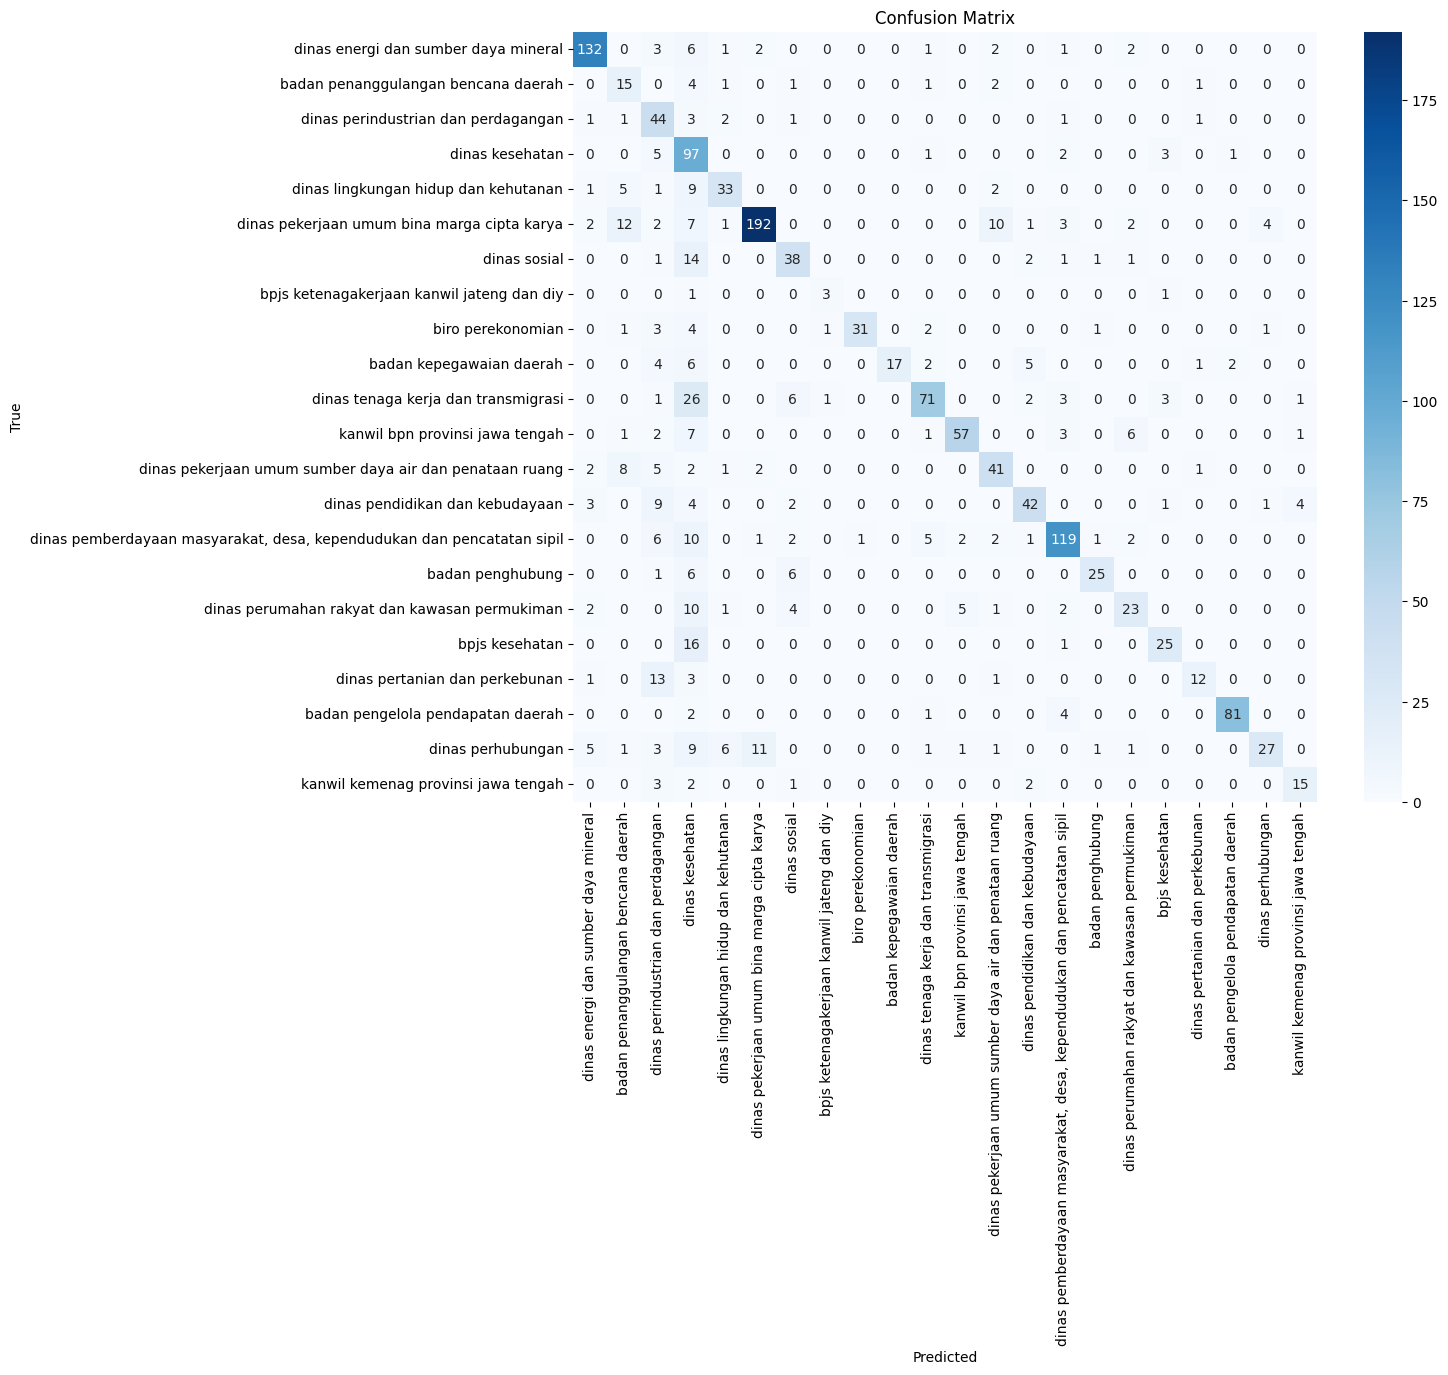

Classification Report:
                                                                         precision    recall  f1-score   support

                                  dinas energi dan sumber daya mineral       0.89      0.88      0.88       150
                                   badan penanggulangan bencana daerah       0.34      0.60      0.43        25
                                   dinas perindustrian dan perdagangan       0.42      0.81      0.55        54
                                                       dinas kesehatan       0.39      0.89      0.54       109
                                  dinas lingkungan hidup dan kehutanan       0.72      0.65      0.68        51
                           dinas pekerjaan umum bina marga cipta karya       0.92      0.81      0.86       236
                                                          dinas sosial       0.62      0.66      0.64        58
                            bpjs ketenagakerjaan kanwil jateng dan diy       0.

In [ ]:
# Assuming your model and datasets are already defined and trained
# Predictions for the test set
predictions = model.predict(test_dataset)

# Convert the predictions and true labels to numerical format
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# List of class names
class_names = list(label_map.keys())

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate detailed classification report
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

## Saving & Embedding Projector

In [ ]:
model.summary()
# Save the model in .h5 format
#model.save('/content/drive/MyDrive/Skripsi/model_aduan')
#model.save_weights('/content/drive/MyDrive/Skripsi/model_aduan_weights')
#model.save('model')

# Save the model without TextVectorization
# Clone the model excluding the TextVectorization layer


"""model_without_textvec = tf.keras.Sequential()
for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.TextVectorization):
        model_without_textvec.add(layer)
model_without_textvec.summary()
model_without_textvec.save('/path/to/your/model_without_textvec.h5')"""

import time
formatted_accuracy = f"{test_acc:.2f}"
timestamp = datetime.now().strftime("%H-%d")
filename = f"/content/drive/MyDrive/Skripsi/model-{formatted_accuracy}-{timestamp}"
model.save(filename, save_format='tf')
print(f"Model saved as {filename}")


#model.save('/content/drive/MyDrive/Skripsi/model_renamed_textvec', overwrite=True)
#tf.keras.models.save_model(model=model, filepath='/content/drive/MyDrive/Skripsi/model_renamed_textvec', overwrite=True)
#model.export('/content/drive/MyDrive/Skripsi/model_renamed_textvec', format='tf_saved_model')
# Print model summary
#model.save('/content/drive/MyDrive/Skripsi/modelv280', save_format='tf')
#model.save_weights('/model_with_textvec.weights.h5')



In [ ]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")

    # Check if the layer has a dtype_policy attribute
    if hasattr(layer, 'dtype_policy'):
        print(f"  DTypePolicy: {layer.dtype_policy}")

    # You can also check other custom attributes or configurations
    config = layer.get_config()
    for key, value in config.items():
        if isinstance(value, tf.keras.mixed_precision.DTypePolicy):
            print(f"  Custom DTypePolicy found in {key}: {value}")
        elif isinstance(value, dict):
            # Check for nested custom objects in config
            for nested_key, nested_value in value.items():
                if isinstance(nested_value, tf.keras.mixed_precision.DTypePolicy):
                    print(f"  Custom DTypePolicy found in {nested_key}: {nested_value}")

    print()  # For better readability

In [ ]:


# Save the model architecture to JSON file
model_json = model.to_json()
with open('my_model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
# Convert label_map to a list of class labels
class_labels = [key for key, value in sorted(label_map.items(), key=lambda item: item[1])]

# Print the formatted class labels
print("class_labels =", class_labels)

# Save class labels to a text file
with open("class_labels.txt", "w") as file:
    file.write("class_labels = " + str(class_labels))

print("Class labels saved to class_labels.txt file.")

In [ ]:


log_dir = 'logs/text-embeddings/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels (Vocabulary) separately
vocab = encoder.get_vocabulary()
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for word in vocab:
        f.write(f"{word}\n")

# Save the weights we want to analyze as a variable.
weights = tf.Variable(model.layers[1].get_weights()[0][1:]) # Skip the padding token
# Create a checkpoint from embedding
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))


In [ ]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)


In [ ]:
%tensorboard --logdir logs/text-embeddings/

In [ ]:
%reload_ext tensorboard

## Live Predict

In [ ]:
# Retrieve a batch of text messages and labels from the test set
text_batch, label_batch = next(iter(test_dataset))

# Predict labels for the text batch
predictions = model.predict_on_batch(text_batch)

# Apply softmax to convert logits to probabilities
predictions_prob = tf.nn.softmax(predictions)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions_prob, axis=1).numpy()

# Get the class probabilities
probabilities = predictions_prob.numpy()

# Define class names if available (replace with your actual class names)
class_names = [
    "dinas pekerjaan umum",
    "kepolisian daerah jawa tengah",
    "dinas kesehatan",
]  # Add your class names here

# Print the results for each text message
for i in range(len(text_batch)):
    print(f"Text: {text_batch[i].numpy().decode('utf-8')}")
    print(
        "True Label:", label_batch[i].numpy() + 1
    )  # Add 1 to match index with class label
    print("Predicted Label:", predicted_class_indices[i] + 1)
    print("Class Probabilities:")
    for j in range(len(probabilities[i])):
        print(f"{probabilities[i][j]} {class_names[j]}")
    print()

In [ ]:
sample_text = (
    "Text: bpkb motor saya hilang mau ngurus di polres wonosobo saya tanya biayanya sekitar apakah benar "
)
predictions = model.predict(np.array([sample_text]))
print(predictions)
# print(label_map)

# Get the predicted label with the highest probability
predicted_label_index = np.argmax(predictions)

print("Probability:", predictions[0][predicted_label_index])


# Function to get the key from a given value
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # If value is not found in the dictionary


# Example usage
value_to_find = np.argmax(predictions)
key_for_value = get_key_from_value(label_map, value_to_find)
if key_for_value is not None:
    print("Numeric label", value_to_find, "is:", key_for_value)
else:
    print("Value", value_to_find, "not found in the dictionary.")

In [ ]:
print(label_map)